<a href="https://colab.research.google.com/github/MaryamNourii/EmotionDetection/blob/Define_Train_Model/ED_Bert_fa_Armandataset_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q transformers

In [ ]:
!pip install keras-adamw

In [ ]:
!pip install tensorflow_addons

In [4]:

from transformers import AutoConfig, AutoTokenizer, TFAutoModel,TFBertForSequenceClassification

import tensorflow as tf
from keras import layers
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from transformers import TFBertModel, BertTokenizerFast, BertConfig

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow_addons.optimizers import AdamW


In [5]:
MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'

In [6]:
data = pd.read_csv('/content/CleanData_arman.csv', sep=',')

In [ ]:
data[data['text'].isnull()]

In [8]:
class_names = ['SAD', 'HATE', 'FEAR', 'ANGRY', 'HAPPY', 'SURPRISE', 'OTHER']
data['target'] = data['label'].map({'SAD':0, 'HATE':1, 'FEAR':2, 'ANGRY':3, 'HAPPY':4, 'SURPRISE':5, 'OTHER':6})
data_x = data['text']
data_y = data['target']

In [9]:
max_length = data_x.apply(lambda x: len(x.split())).max()
max_length  

48

In [ ]:
config = BertConfig.from_pretrained(MODEL_NAME_OR_PATH, output_hidden_states=False)
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = MODEL_NAME_OR_PATH, config = config)
transformer_model = TFAutoModel.from_pretrained(MODEL_NAME_OR_PATH, config = config)

In [11]:
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
attention_mask = Input(shape=(max_length,), name='attention_mask', dtype='int32')
token_ids = Input(shape=(max_length,), name='token_ids', dtype='int32')
inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}

bert_model = transformer_model(inputs)[1]
pooled_output = Dropout(config.hidden_dropout_prob, name='pooled_output')(bert_model, training=False)

emotion = Dense(units=7, activation="sigmoid", kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='emotion')(pooled_output)
outputs = emotion

model = Model(inputs=inputs, outputs=outputs, name='BERT_MultiLabel')


In [12]:
model.layers[2].trainable = True

In [13]:
model.summary()   

Model: "BERT_MultiLabel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 48)]         0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 48)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  162841344   ['attention_mask[0][0]',         
                                thPoolingAndCrossAt               'input_ids[0][0]']              
                                tentions(last_hidde                                               
                                n_state=(None, 48,                                  

In [14]:
train_x,test_x,train_y,test_y = train_test_split(data_x,data_y,test_size=0.2)
train_x,val_x,train_y,val_y = train_test_split(train_x,train_y,test_size=0.1)

In [15]:
train_token = tokenizer(
    text = train_x.to_list(),
    add_special_tokens = True,
    max_length = max_length,
    truncation = True,
    padding = 'max_length', 
    return_tensors = 'tf',
    return_token_type_ids = True,
    return_attention_mask = True,
    verbose = True)

val_token = tokenizer(
    text = val_x.to_list(),
    add_special_tokens = True,
    max_length = max_length,
    truncation = True,
    padding = 'max_length', 
    return_tensors = 'tf',
    return_token_type_ids = True,
    return_attention_mask = True,
    verbose = True)

test_token = tokenizer(
    text = test_x.to_list(),
    add_special_tokens = True,
    max_length = max_length,
    truncation = True,
    padding = 'max_length', 
    return_tensors = 'tf',
    return_token_type_ids = True,
    return_attention_mask = True,
    verbose = True)

In [16]:
train = {'input_ids': train_token['input_ids'], 'attention_mask': train_token['attention_mask'],'token_ids': train_token['token_type_ids']}
val = {'input_ids': val_token['input_ids'], 'attention_mask': val_token['attention_mask'],'token_ids': val_token['token_type_ids']}
test = {'input_ids': test_token['input_ids'], 'attention_mask': test_token['attention_mask'],'token_ids': test_token['token_type_ids']}

In [17]:
train_tensor = tf.data.Dataset.from_tensor_slices((train, train_y)).shuffle(len(train)).batch(16)
val_tensor = tf.data.Dataset.from_tensor_slices((val, val_y)).shuffle(len(val)).batch(16)
test_tensor = tf.data.Dataset.from_tensor_slices((test, test_y)).shuffle(len(test)).batch(16)

In [18]:
optimizer = Adam(
    learning_rate=6e-06,
    epsilon=1e-08,
    decay = 1e-07)


loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(
    optimizer = optimizer,
    loss = loss,
    metrics = [metric])


log_dir='tb_bert'
model_save_path='bert_model.h5'
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,
                                                save_weights_only=True,
                                                monitor='val_loss',mode='min'
                                                ,save_best_only=True),
                                                tf.keras.callbacks.TensorBoard(log_dir=log_dir)]

history = model.fit(train_tensor, 
                    epochs=4, 
                    validation_data=val_tensor,
                    callbacks=callbacks, shuffle=True)

Epoch 1/4


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['token_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


293/293 [==============================] - 91s 230ms/step - loss: 1.7365 - accuracy: 0.3312 - val_loss: 1.3083 - val_accuracy: 0.5835
Epoch 2/4
293/293 [==============================] - 64s 219ms/step - loss: 1.2201 - accuracy: 0.5833 - val_loss: 1.0905 - val_accuracy: 0.6065
Epoch 3/4
293/293 [==============================] - 64s 218ms/step - loss: 0.9726 - accuracy: 0.6709 - val_loss: 1.0604 - val_accuracy: 0.6238
Epoch 4/4
293/293 [==============================] - 61s 209ms/step - loss: 0.7821 - accuracy: 0.7429 - val_loss: 1.0826 - val_accuracy: 0.6123


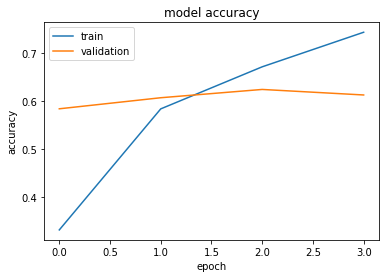

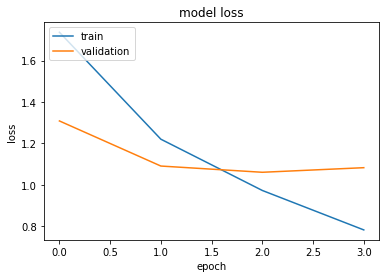

In [20]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()



In [21]:
pred_y = model.predict(test_tensor)
predictions = np.argmax(pred_y, axis=1)

82/82 [==============================] - 8s 69ms/step


In [22]:
print("Accuracy: {:.2f}%".format(accuracy_score(test_y, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(test_y, predictions, average='micro') * 100))

Accuracy: 21.60%

F1 Score: 21.60


In [17]:
optimizer = AdamW(lr=6e-6,weight_decay=1e-07)


loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(
    optimizer = optimizer,
    loss = loss,
    metrics = [metric])


log_dir='tb_bert'
model_save_path='bert_model.h5'
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,
                                                save_weights_only=True,
                                                monitor='val_loss',mode='min'
                                                ,save_best_only=True),
                                                tf.keras.callbacks.TensorBoard(log_dir=log_dir)]

history = model.fit(train_tensor, 
                    epochs=4, 
                    validation_data=val_tensor,
                    callbacks=callbacks, shuffle=True)

Epoch 1/4


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['token_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


293/293 [==============================] - 87s 240ms/step - loss: 1.7225 - accuracy: 0.3470 - val_loss: 1.4148 - val_accuracy: 0.5010
Epoch 2/4
293/293 [==============================] - 67s 228ms/step - loss: 1.2075 - accuracy: 0.5833 - val_loss: 1.1753 - val_accuracy: 0.5758
Epoch 3/4
293/293 [==============================] - 68s 231ms/step - loss: 0.9465 - accuracy: 0.6863 - val_loss: 1.1302 - val_accuracy: 0.5950
Epoch 4/4
293/293 [==============================] - 65s 223ms/step - loss: 0.7402 - accuracy: 0.7588 - val_loss: 1.1606 - val_accuracy: 0.5988


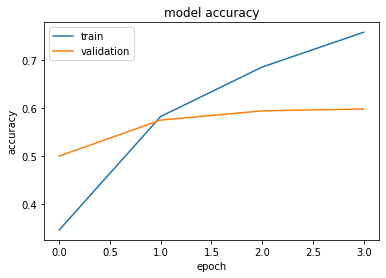

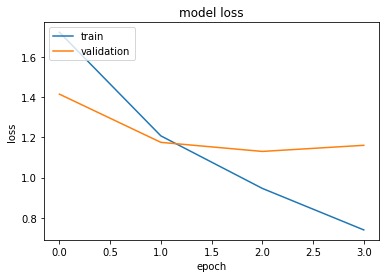

In [21]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()



In [22]:
pred_y = model.predict(test_tensor)
predictions = np.argmax(pred_y, axis=1)

82/82 [==============================] - 5s 64ms/step


In [23]:
print("Accuracy: {:.2f}%".format(accuracy_score(test_y, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(test_y, predictions, average='micro') * 100))

Accuracy: 22.29%

F1 Score: 22.29
